In [1]:
# Import libraries
from pyspark.sql import *
from pyspark.sql.functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psutil
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import json
import warnings
warnings.filterwarnings("ignore")

# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Random forest
from sklearn.ensemble import RandomForestRegressor

# Gaussian process
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch
import gpytorch

# Neural network
from sklearn.neural_network import MLPRegressor

# Gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

# Import own functions
import helperFuncs as hf
import metrics
import methods

In [ ]:
%matplotlib inline

In [32]:
%load_ext autoreload
%autoreload 2

In [2]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

# Create spark context
sc = spark.sparkContext

# Check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

24/05/30 16:41:54 WARN Utils: Your hostname, CC-M133A-EU.local resolves to a loopback address: 127.0.0.1; using 10.0.0.72 instead (on interface en0)
24/05/30 16:41:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/30 16:41:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Total Memory Allocated to Spark Runtime: 32 GB


In [3]:
# Load data
folder = '/Users/ekinokos2/Downloads/2023-citibike-tripdata/9_September/'
name = '202309-citibike-tripdata_4.csv'
path = folder + name

sep23_data = spark.read.csv(path, sep = ',', header = True, inferSchema = True)

In [5]:
sep23_data_pd = pd.read_csv(path)

/var/folders/84/204q7trx39741y4p1_tyrh6m0000gp/T/ipykernel_37832/1334132814.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sep23_data_pd = pd.read_csv(path)


In [4]:
# Choose which dataset
data = sep23_data

# View data
print(f"NUM DATA POINTS = {data.count()}")
data.show()

NUM DATA POINTS = 575162
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|E7CE7CE80519EB26| classic_bike|2023-09-16 17:15:28|2023-09-16 17:19:00|Halsey St & Ralph...|         4334.02|Broadway & Madiso...|       4483.10|          40.68494|         -73.92299|         40.68822|         -73.91966|       member|
|56F4C65B769CF128| classic_bike

In [5]:
# Project only relevant columns
projected_data = data.select("started_at", "ended_at", "start_lat", "start_lng",
                  "end_lat", "end_lng")

# Select a small sample (first N) of rows
N = 1000
small_data = projected_data.select("*").limit(N)

# Test function
test = hf.extract_times_to_seconds(small_data)
test.show()

+------------------+------------------+-----------------+------------------+-------------+-----------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_seconds|end_seconds|
+------------------+------------------+-----------------+------------------+-------------+-----------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|        62128|      62340|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|        78329|      78813|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        43198|      44582|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|        32947|      33267|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        74065|      74516|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        76446|      77789|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.966800570487

In [6]:
# Search for best lambda and gamma
# Collect working dataset into an array
small_time_and_space = hf.extract_times_to_seconds(small_data)
small_time_and_space_arr = np.array(small_time_and_space.collect())

# Normalize the data
scaler = StandardScaler()
scaler.fit(small_time_and_space_arr)
small_time_and_space_arr = scaler.transform(small_time_and_space_arr)

In [28]:
lam_search = [0.9, 0.7, 0.5, 0.3, 0.1]
gam_search = [0.1, 0.5, 1.0, 1.5, 3.0]

for lam in lam_search:
    for gam in gam_search:
        # Set k, the number of clusters for K-means
        k = 5

        # Pick the first k points as a "random" initialization of centroids
        random_centroids = small_time_and_space_arr[:k]

        # Run k-means time & space algorithm on small_space_and_time data
        # lam (a hyper-parameter between 0 and 1) controls how much we weight space
        # vs. time in our calculation of the cost. The smaller lam is, the more space
        # is weighted.
        costs, centroids, clustering = hf.K_means_time_and_space(small_time_and_space_arr,
                                                            random_centroids,
                                                            max_iter = 10, norm = 2,
                                                            lam = lam,
                                                            gam = gam)
        # Plot the cost vs. iteration
        #plt.plot(costs)
        #plt.xlabel("Iteration")
        #plt.ylabel("Cost")
        #plt.title(f"Cost vs. Iteration for Lambda = {lam}, Gamma = {gam}")
        #plt.show()

        overall_score, sample_scores = hf.silhouette_score_custom(small_time_and_space_arr, clustering, hf.custom_distance_metric, lam, gam)
        print(f"Lambda = {lam}, Gamma = {gam}, Overall Silhouette  Score {overall_score}")

Lambda = 0.9, Gamma = 0.1, Overall Silhouette  Score 0.3729527852828081
Lambda = 0.9, Gamma = 0.5, Overall Silhouette  Score 0.37269928906311334
Lambda = 0.9, Gamma = 1.0, Overall Silhouette  Score 0.3723830184413008
Lambda = 0.9, Gamma = 1.5, Overall Silhouette  Score 0.37206741191487336
Lambda = 0.9, Gamma = 3.0, Overall Silhouette  Score 0.37112455366888436
Lambda = 0.7, Gamma = 0.1, Overall Silhouette  Score 0.38196284643434814
Lambda = 0.7, Gamma = 0.5, Overall Silhouette  Score 0.381694921300087
Lambda = 0.7, Gamma = 1.0, Overall Silhouette  Score 0.38136066916303785
Lambda = 0.7, Gamma = 1.5, Overall Silhouette  Score 0.3810271415335652
Lambda = 0.7, Gamma = 3.0, Overall Silhouette  Score 0.3800308794232987
Lambda = 0.5, Gamma = 0.1, Overall Silhouette  Score 0.38382632728703164
Lambda = 0.5, Gamma = 0.5, Overall Silhouette  Score 0.3835553559276871
Lambda = 0.5, Gamma = 1.0, Overall Silhouette  Score 0.3832173078205451
Lambda = 0.5, Gamma = 1.5, Overall Silhouette  Score 0.3828

## Outline of the remaining work
* Implement models to predict the arrival time using
    * Linear regression
    * Random forest
    * Gradient boosting
    * Neural network
    * Gaussian process
* Compare the performance of the models when run with the entire set of data and when run with the subset of data belonging to the specific cluster
* Compare our clustering approach with Euclidian distance clustering

In [7]:
# Project only relevant columns
projected_data = data.select("started_at", "ended_at", "start_lat", "start_lng",
                  "end_lat", "end_lng")

# Select a small sample (first N) of rows
N = 10000
small_data = projected_data.select("*").limit(N)

# Search for best lambda and gamma
# Collect working dataset into an array
small_time_and_space = hf.extract_times_to_seconds(small_data)
small_time_and_space_arr = np.array(small_time_and_space.collect())

# Normalize the data
scaler = StandardScaler()
scaler.fit(small_time_and_space_arr)
small_time_and_space_arr = scaler.transform(small_time_and_space_arr)

# Set k, the number of clusters for K-means
k = 5

lam = 0.5
gam = 1.0

# Pick the first k points as a "random" initialization of centroids
random_centroids = small_time_and_space_arr[:k]

# Run k-means time & space algorithm on small_space_and_time data
# lam (a hyper-parameter between 0 and 1) controls how much we weight space
# vs. time in our calculation of the cost. The smaller lam is, the more space
# is weighted.
costs, centroids, clustering = hf.K_means_time_and_space(small_time_and_space_arr,
                                                    random_centroids,
                                                    max_iter = 10, norm = 2,
                                                    lam = lam,
                                                    gam = gam)

In [8]:
# Add clustering to the dataframe
small_time_and_space_arr_pd = pd.DataFrame(small_time_and_space_arr)
small_time_and_space_arr_pd.columns = ["start_lat", "start_lng", "end_lat", "end_lng", "start_time", "end_time"]
small_time_and_space_arr_pd["cluster"] = clustering

# Assuming 'data' is the DataFrame containing the data
# and 'clustering' is the numpy array containing the cluster values

cluster_train_test_splits = hf.cluster_train_test_split(small_time_and_space_arr_pd)


# Also do a regular train/test split
X = small_time_and_space_arr_pd.drop(columns=["cluster", "end_time"])
y = small_time_and_space_arr_pd["end_time"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
small_time_and_space_arr_pd["cluster"].value_counts()

1.0    2906
0.0    2783
2.0    1966
3.0    1176
4.0    1169
Name: cluster, dtype: int64

In [10]:
# Train a linear regression model for each cluster
linear_regression_models = {}
lr_cluster_times = {}
for cluster in cluster_train_test_splits:
    start = time.time()
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    model = LinearRegression()
    model.fit(train_x, train_y)
    linear_regression_models[cluster] = model
    end = time.time()
    lr_cluster_times[cluster] = end - start

# Evaluate the linear regression models
linear_regression_mse = {}
lr_cluster_results = {}
for cluster in linear_regression_models:
    model = linear_regression_models[cluster]
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    predictions = model.predict(test_x)
    mse = mean_squared_error(test_y, predictions)
    linear_regression_mse[cluster] = mse
    results = metrics.evaluate(test_y, predictions)
    lr_cluster_results[cluster] = results

# Also do a regular train/test split
X = small_time_and_space_arr_pd.drop(columns=["cluster", "end_time"])
y = small_time_and_space_arr_pd["end_time"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model for the entire dataset
model = LinearRegression()
start = time.time()
model.fit(train_x, train_y)
end = time.time()
lr_time = end - start
predictions = model.predict(test_x)
lr_mse = mean_squared_error(test_y, predictions)
lr_entire_results = metrics.evaluate(test_y, predictions)

print(f"Training time for entire dataset: {lr_time}")
print()
print(f"Linear Regression MSE for Entire Dataset: {lr_mse}")
print()
print("Linear Regression Training Times for Each Cluster:")
for cluster in lr_cluster_times:
    print(f"Cluster {cluster}: {lr_cluster_times[cluster]}")
print()
print("Linear Regression MSE for Each Cluster:")
for cluster in linear_regression_mse:
    print(f"Cluster {cluster}: {linear_regression_mse[cluster]}")

# Print the average of all entries in lr_cluster_results
print()
print("Average of all entries in lr_cluster_results:")
lr_cluster_results_pd = pd.DataFrame(lr_cluster_results)
print(lr_cluster_results_pd.mean(axis=1))

Training time for entire dataset: 0.0012881755828857422

Linear Regression MSE for Entire Dataset: 0.12155805688854653

Linear Regression Training Times for Each Cluster:
Cluster 0.0: 0.0018339157104492188
Cluster 1.0: 0.0020568370819091797
Cluster 2.0: 0.0009860992431640625
Cluster 3.0: 0.0012049674987792969
Cluster 4.0: 0.0007288455963134766

Linear Regression MSE for Each Cluster:
Cluster 0.0: 0.039213024809092306
Cluster 1.0: 0.14505166299762787
Cluster 2.0: 0.003318368760180141
Cluster 3.0: 0.01796160488738441
Cluster 4.0: 0.1765149867168799

Average of all entries in lr_cluster_results:
MAE        0.069936
RMSE       0.238128
MAD        0.045427
MAPE       0.252623
MAXAPE    33.926156
TAPE      97.099360
dtype: float64


In [11]:
lr_entire_results

{'MAE': 0.0711493164406142,
 'RMSE': 0.34865177023578486,
 'MAD': 0.037222118158097006,
 'MAPE': 0.17124203540145422,
 'MAXAPE': 18.954042224448255,
 'TAPE': 342.48407080290843}

In [14]:
# Train a random forest model for each cluster
random_forest_models = {}
rf_cluster_times = {}
for cluster in cluster_train_test_splits:
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    model = RandomForestRegressor()
    start = time.time()
    model.fit(train_x, train_y)
    end = time.time()
    rf_cluster_times[cluster] = end - start
    random_forest_models[cluster] = model

# Evaluate the random forest models
random_forest_mse = {}
for cluster in random_forest_models:
    model = random_forest_models[cluster]
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    predictions = model.predict(test_x)
    mse = mean_squared_error(test_y, predictions)
    random_forest_mse[cluster] = mse
    
# Also do a regular train/test split
X = small_time_and_space_arr_pd.drop(columns=["cluster", "end_time"])
y = small_time_and_space_arr_pd["end_time"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest model for the entire dataset
model = RandomForestRegressor()
start = time.time()
model.fit(train_x, train_y)
end = time.time()
rf_time = end - start
predictions = model.predict(test_x)
mse = mean_squared_error(test_y, predictions)

print(f"Training Time for Entire Dataset: {rf_time}")
print()
print(f"Random Forest MSE for Entire Dataset: {mse}")
print()
print("Random Forest Training Times for Each Cluster:")
for cluster in rf_cluster_times:
    print(f"Cluster {cluster}: {rf_cluster_times[cluster]}")
print()
print("Random Forest MSE for Each Cluster:")
for cluster in random_forest_mse:
    print(f"Cluster {cluster}: {random_forest_mse[cluster]}")

Training Time for Entire Dataset: 2.2465171813964844

Random Forest MSE for Entire Dataset: 0.043384756654168626

Random Forest Training Times for Each Cluster:
Cluster 0.0: 0.5286421775817871
Cluster 1.0: 0.5370738506317139
Cluster 2.0: 0.35738706588745117
Cluster 3.0: 0.21899890899658203
Cluster 4.0: 0.21520614624023438

Random Forest MSE for Each Cluster:
Cluster 0.0: 0.02144629111257377
Cluster 1.0: 0.03772802743462243
Cluster 2.0: 0.005291408981845475
Cluster 3.0: 0.08192402372832287
Cluster 4.0: 0.15909367869171734


In [15]:
# Train a neural network model for each cluster
neural_network_models = {}
nn_cluster_times = {}
for cluster in cluster_train_test_splits:
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    model = MLPRegressor()
    start = time.time()
    model.fit(train_x, train_y)
    end = time.time()
    nn_cluster_times[cluster] = end - start
    neural_network_models[cluster] = model

# Evaluate the neural network models
neural_network_mse = {}
for cluster in neural_network_models:
    model = neural_network_models[cluster]
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    predictions = model.predict(test_x)
    mse = mean_squared_error(test_y, predictions)
    neural_network_mse[cluster] = mse

# Also do a regular train/test split
X = small_time_and_space_arr_pd.drop(columns=["cluster", "end_time"])
y = small_time_and_space_arr_pd["end_time"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a neural network model for the entire dataset
model = MLPRegressor()
start = time.time()
model.fit(train_x, train_y)
end = time.time()
nn_time = end - start
predictions = model.predict(test_x)
mse = mean_squared_error(test_y, predictions)

print(f"NN Training Time for Entire Dataset: {nn_time}")
print()
print(f"NN MSE for Entire Dataset: {mse}")
print()
print("NN Training Times for Each Cluster:")
for cluster in nn_cluster_times:
    print(f"Cluster {cluster}: {nn_cluster_times[cluster]}")
print()
print("NN MSE for Each Cluster:")
for cluster in neural_network_mse:
    print(f"Cluster {cluster}: {neural_network_mse[cluster]}")

/Users/ekinokos2/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekinokos2/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ekinokos2/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


NN Training Time for Entire Dataset: 2.6895737648010254

NN MSE for Entire Dataset: 0.08650308140077245

NN Training Times for Each Cluster:
Cluster 0.0: 0.7068591117858887
Cluster 1.0: 0.7510719299316406
Cluster 2.0: 0.1628129482269287
Cluster 3.0: 0.3173229694366455
Cluster 4.0: 0.09429192543029785

NN MSE for Each Cluster:
Cluster 0.0: 0.036605677170569006
Cluster 1.0: 0.1173815393100648
Cluster 2.0: 0.007457718034959324
Cluster 3.0: 0.026199237086368052
Cluster 4.0: 0.17337422702407582


/Users/ekinokos2/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
num_epochs = 25
gp_lr = 0.1
    
# Train a Gaussian process model for each cluster
gaussian_process_models = {}
gp_cluster_times = {}
for cluster in cluster_train_test_splits:
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    train_x = torch.tensor(train_x.values).float()
    train_y = torch.tensor(train_y.values).float()
    likelihood = GaussianLikelihood()
    model = methods.GPModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()
    mll = ExactMarginalLogLikelihood(likelihood, model)
    optimizer = torch.optim.Adam(model.parameters(), lr=gp_lr)
    start = time.time()
    for i in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
    end = time.time()
    gp_cluster_times[cluster] = end - start
    gaussian_process_models[cluster] = model

# Evaluate the Gaussian process models
gaussian_process_mse = {}
for cluster in gaussian_process_models:
    model = gaussian_process_models[cluster]
    test_x, test_y = cluster_train_test_splits[cluster][1], cluster_train_test_splits[cluster][3]
    test_x = torch.tensor(test_x.values).float()
    test_y = torch.tensor(test_y.values).float()
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = model(test_x)
        mse = mean_squared_error(test_y, predictions.mean)
        gaussian_process_mse[cluster] = mse

# Also do a regular train/test split
X = small_time_and_space_arr_pd.drop(columns=["cluster", "end_time"])
y = small_time_and_space_arr_pd["end_time"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gaussian process model for the entire dataset
train_x = torch.tensor(train_x.values).float()
train_y = torch.tensor(train_y.values).float()
likelihood = GaussianLikelihood()
model = methods.GPModel(train_x, train_y, likelihood)
model.train()
likelihood.train()
mll = ExactMarginalLogLikelihood(likelihood, model)
optimizer = torch.optim.Adam(model.parameters(), lr=gp_lr)
start = time.time()
for i in range(num_epochs):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
end = time.time()
gp_time = end - start
test_x = torch.tensor(test_x.values).float()
test_y = torch.tensor(test_y.values).float()
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model(test_x)
    mse = mean_squared_error(test_y, predictions.mean)

print(f"GP Training Time for Entire Dataset: {gp_time}")
print()
print(f"GP MSE for Entire Dataset: {mse}")
print()
print("GP Training Times for Each Cluster:")
for cluster in gp_cluster_times:
    print(f"Cluster {cluster}: {gp_cluster_times[cluster]}")
print()
print("GP MSE for Each Cluster:")
for cluster in gaussian_process_mse:
    print(f"Cluster {cluster}: {gaussian_process_mse[cluster]}")


GP Training Time for Entire Dataset: 12.097362041473389

GP MSE for Entire Dataset: 0.06379331648349762

GP Training Times for Each Cluster:
Cluster 0.0: 1.7533986568450928
Cluster 1.0: 1.734299898147583
Cluster 2.0: 0.6195230484008789
Cluster 3.0: 0.3039207458496094
Cluster 4.0: 0.30571484565734863

GP MSE for Each Cluster:
Cluster 0.0: 0.03782009333372116
Cluster 1.0: 0.06882806122303009
Cluster 2.0: 0.009221695363521576
Cluster 3.0: 0.043596670031547546
Cluster 4.0: 0.1631726324558258


In [18]:
# Train a gradient boosting model for each cluster
gradient_boosting_models = {}
gb_cluster_times = {}
for cluster in cluster_train_test_splits:
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    model = GradientBoostingRegressor()
    start = time.time()
    model.fit(train_x, train_y)
    end = time.time()
    gb_cluster_times[cluster] = end - start
    gradient_boosting_models[cluster] = model

# Evaluate the gradient boosting models
gradient_boosting_mse = {}
for cluster in gradient_boosting_models:
    model = gradient_boosting_models[cluster]
    train_x, test_x, train_y, test_y = cluster_train_test_splits[cluster]
    predictions = model.predict(test_x)
    mse = mean_squared_error(test_y, predictions)
    gradient_boosting_mse[cluster] = mse

# Also do a regular train/test split
X = small_time_and_space_arr_pd.drop(columns=["cluster", "end_time"])
y = small_time_and_space_arr_pd["end_time"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a gradient boosting model for the entire dataset
model = GradientBoostingRegressor()
start = time.time()
model.fit(train_x, train_y)
end = time.time()
gb_time = end - start
predictions = model.predict(test_x)
mse = mean_squared_error(test_y, predictions)

print(f"Training time for entire dataset: {gb_time}")
print()
print(f"Gradient Boosting MSE for Entire Dataset: {mse}")
print()
print("Gradient Boosting Training Times for Each Cluster:")
for cluster in gb_cluster_times:
    print(f"Cluster {cluster}: {gb_cluster_times[cluster]}")
print()
print("Gradient Boosting MSE for Each Cluster:")
for cluster in gradient_boosting_mse:
    print(f"Cluster {cluster}: {gradient_boosting_mse[cluster]}")

Training time for entire dataset: 0.8310761451721191

Gradient Boosting MSE for Entire Dataset: 0.03814455236191411

Gradient Boosting Training Times for Each Cluster:
Cluster 0.0: 0.22678589820861816
Cluster 1.0: 0.2177867889404297
Cluster 2.0: 0.15129613876342773
Cluster 3.0: 0.09425926208496094
Cluster 4.0: 0.09214210510253906

Gradient Boosting MSE for Each Cluster:
Cluster 0.0: 0.026964058798025135
Cluster 1.0: 0.037025286744018095
Cluster 2.0: 0.006013536929567091
Cluster 3.0: 0.09805893359151696
Cluster 4.0: 0.1755063411688478


# FULL SENSITIVITY ANALYSIS

In [40]:
# List of all parameters for sensitivity analysis
# [k, lam, gam, N, norm]

N = [50000]
norms = [1, 2]
lams = [0.1, 0.5, 0.9]
gams = [0.5, 1.0, 2.0]
K = [3, 4, 5, 6, 7]
test_size = 0.2
random_state = 42
max_iters = 10
num_epochs = 25
gp_lr = 0.1

verbose = False
gp_flag = False

# Load data
folder = '/Users/ekinokos2/Downloads/2023-citibike-tripdata/9_September/'
name = '202309-citibike-tripdata_4.csv'
path = folder + name

data = spark.read.csv(path, sep = ',', header = True, inferSchema = True)

# Project only relevant columns
projected_data = data.select("started_at", "ended_at", "start_lat", "start_lng",
                             "end_lat", "end_lng")

# First randomly sample 50000 points from the data
projected_data = projected_data.sample(withReplacement=False, fraction=0.3, seed=random_state)

# Run sensitivity analysis
for n in N:
    for norm in norms:
        for lam in lams:
            for gam in gams:
                for k in K:
                    print(f"N = {n}, Norm = {norm}, Lambda = {lam}, Gamma = {gam}, K = {k}")
                    print()
                    
                    # Out of projected data, Choose first n points
                    small_data = projected_data.select("*").limit(n)
                    
                    # Collect working dataset into an array
                    small_time_and_space = hf.extract_times_to_seconds(small_data)
                    small_time_and_space_arr = np.array(small_time_and_space.collect())

                    # Pick a random initialization of centroids
                    random_centroids = small_time_and_space_arr[:k]

                    # Run k-means time & space algorithm on small_space_and_time data
                    # lam (a hyper-parameter between 0 and 1) controls how much we weight space
                    # vs. time in our calculation of the cost. The smaller lam is, the more space
                    # is weighted.
                    costs_custom, centroids_custom, clustering_custom = hf.K_means_time_and_space_alt(small_time_and_space_arr,
                                                                        random_centroids,
                                                                        max_iter = max_iters, norm = norm,
                                                                        lam = lam,
                                                                        gam = gam,
                                                                        dist_func = hf.custom_distance_metric)
                    
                    # Add clustering to the dataframe
                    small_time_and_space_arr_pd = pd.DataFrame(small_time_and_space_arr)
                    small_time_and_space_arr_pd.columns = ["start_lat", "start_lng", "end_lat", "end_lng", "start_time", "end_time"]
                    small_time_and_space_arr_pd["cluster_custom"] = clustering_custom

                    costs_euc, centroids_euc, clustering_euc = hf.K_means_time_and_space_alt(small_time_and_space_arr,
                                                                        random_centroids,
                                                                        max_iter = max_iters, norm = norm,
                                                                        lam = lam,
                                                                        gam = gam,
                                                                        dist_func = hf.euclidean_dist)

                    cluster_train_test_splits, cluster_scalers = hf.cluster_train_test_split(small_time_and_space_arr_pd, cluster_col = "cluster_custom", test_size=test_size, random_state=random_state)
                    
                    # Drop the custom clusters from the dataframe
                    small_time_and_space_arr_pd = small_time_and_space_arr_pd.drop(columns=["cluster_custom"])
                    
                    # Add euclidian clusters to the dataframe
                    small_time_and_space_arr_pd["cluster_euc"] = clustering_euc

                    cluster_euc_train_test_splits, clusters_euc_scalers = hf.cluster_train_test_split(small_time_and_space_arr_pd, cluster_col = "cluster_euc", test_size=test_size, random_state=random_state)
                    
                    small_time_and_space_arr_pd["cluster_custom"] = clustering_custom

                    # Linear regression
                    def lr(train_test_splits):
                        linear_regression_models = {}
                        lr_cluster_times = {}
                        for cluster in train_test_splits:
                            start = time.time()
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            model = LinearRegression()
                            model.fit(train_x, train_y)
                            linear_regression_models[cluster] = model
                            end = time.time()
                            lr_cluster_times[cluster] = end - start

                        # Evaluate the linear regression models
                        lr_cluster_results = {}
                        for cluster in linear_regression_models:
                            model = linear_regression_models[cluster]
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            predictions = model.predict(test_x)
                            results = metrics.evaluate(test_y, predictions)
                            lr_cluster_results[cluster] = results

                        return linear_regression_models, lr_cluster_times, lr_cluster_results

                    linear_regression_models, lr_cluster_times, lr_cluster_results = lr(cluster_train_test_splits)
                    lr_euc_models, lr_euc_times, lr_euc_results = lr(cluster_euc_train_test_splits)
                    
                    # Also do a regular train/test split
                    X = small_time_and_space_arr_pd.drop(columns=["cluster_custom","cluster_euc", "end_time"])
                    y = small_time_and_space_arr_pd["end_time"]
                    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)

                    # Normalize the data
                    scaler_input = StandardScaler()
                    scaler_input.fit(train_x)
                    train_x = scaler_input.transform(train_x)
                    test_x = scaler_input.transform(test_x)

                    scaler_output = StandardScaler()
                    scaler_output.fit(train_y.values.reshape(-1, 1))
                    train_y = scaler_output.transform(train_y.values.reshape(-1, 1)).flatten()
                    test_y = scaler_output.transform(test_y.values.reshape(-1, 1)).flatten()


                    # Train a linear regression model for the entire dataset
                    model = LinearRegression()
                    start = time.time()
                    model.fit(train_x, train_y)
                    end = time.time()
                    lr_time = end - start
                    predictions = model.predict(test_x)
                    lr_entire_results = metrics.evaluate(test_y, predictions)

                    lr_euc_results_pd = pd.DataFrame(lr_euc_results)
                    lr_cluster_results_pd = pd.DataFrame(lr_cluster_results)


                    if verbose:
                        print(f"Training time for entire dataset: {lr_time}")
                        print()
                        print("Linear Regression Training Times for Each Cluster:")
                        for cluster in lr_cluster_times:
                            print(f"Cluster {cluster}: {lr_cluster_times[cluster]}")
    
                        # Print the average of all entries in lr_euc_results
                        print()
                        print("Average of all entries in lr_euc_results:")
                        print(lr_euc_results_pd.mean(axis=1))
                        print()

                        # Print the average of all entries in lr_cluster_results
                        print()
                        print("Average of all entries in lr_cluster_results:")
                        print(lr_cluster_results_pd.mean(axis=1))
                        print()
                        print(f"Linear Regression Entire Dataset: {lr_entire_results}")


                    def rf(train_test_splits):
                        random_forest_models = {}
                        rf_cluster_times = {}
                        for cluster in train_test_splits:
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            model = RandomForestRegressor()
                            start = time.time()
                            model.fit(train_x, train_y)
                            end = time.time()
                            rf_cluster_times[cluster] = end - start
                            random_forest_models[cluster] = model

                        rf_cluster_results = {}
                        for cluster in random_forest_models:
                            model = random_forest_models[cluster]
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            predictions = model.predict(test_x)
                            results = metrics.evaluate(test_y, predictions)
                            rf_cluster_results[cluster] = results

                        return random_forest_models, rf_cluster_times, rf_cluster_results

                    random_forest_models, rf_cluster_times, rf_cluster_results = rf(cluster_train_test_splits)
                    random_forest_euc_models, rf_euc_times, rf_euc_results = rf(cluster_euc_train_test_splits)

                    # X = small_time_and_space_arr_pd.drop(columns=["cluster_custom","cluster_euc", "end_time"])
                    # y = small_time_and_space_arr_pd["end_time"]
                    # train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)

                    model = RandomForestRegressor()
                    start = time.time()
                    model.fit(train_x, train_y)
                    end = time.time()
                    rf_time = end - start
                    predictions = model.predict(test_x)
                    rf_entire_results = metrics.evaluate(test_y, predictions)

                    rf_euc_results_pd = pd.DataFrame(rf_euc_results)
                    rf_cluster_results_pd = pd.DataFrame(rf_cluster_results)

                    if verbose:
                        print(f"Training Time for Entire Dataset: {rf_time}")
                        print()
                        print("Random Forest Training Times for Each Cluster:")
                        for cluster in rf_cluster_times:
                            print(f"Cluster {cluster}: {rf_cluster_times[cluster]}")

                        # Print the average of all entries in rf_euc_results
                        print()
                        print("Average of all entries in rf_euc_results:")
                        
                        print(rf_euc_results_pd.mean(axis=1))
                
                        # Print the average of all entries in rf_cluster_results
                        print()
                        print("Average of all entries in rf_cluster_results:")
                        print(rf_cluster_results_pd.mean(axis=1))
                        print()
                        print(f"Random Forest Entire Dataset: {rf_entire_results}")

                    def nn(train_test_splits):
                        neural_network_models = {}
                        nn_cluster_times = {}
                        for cluster in train_test_splits:
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            model = MLPRegressor()
                            start = time.time()
                            model.fit(train_x, train_y)
                            end = time.time()
                            nn_cluster_times[cluster] = end - start
                            neural_network_models[cluster] = model

                        nn_cluster_results = {}
                        for cluster in neural_network_models:
                            model = neural_network_models[cluster]
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            predictions = model.predict(test_x)
                            results = metrics.evaluate(test_y, predictions)
                            nn_cluster_results[cluster] = results

                        return neural_network_models, nn_cluster_times, nn_cluster_results
                    
                    neural_network_models, nn_cluster_times, nn_cluster_results = nn(cluster_train_test_splits)
                    neural_network_euc_models, nn_euc_times, nn_euc_results = nn(cluster_euc_train_test_splits)

                    # X = small_time_and_space_arr_pd.drop(columns=["cluster_custom","cluster_euc", "end_time"])
                    # y = small_time_and_space_arr_pd["end_time"]
                    # train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)

                    model = MLPRegressor()
                    start = time.time()
                    model.fit(train_x, train_y)
                    end = time.time()
                    nn_time = end - start
                    predictions = model.predict(test_x)
                    nn_entire_results = metrics.evaluate(test_y, predictions)

                    nn_euc_results_pd = pd.DataFrame(nn_euc_results)
                    nn_cluster_results_pd = pd.DataFrame(nn_cluster_results)


                    if verbose:
                        print(f"NN Training Time for Entire Dataset: {nn_time}")
                        print()
                        print("NN Training Times for Each Cluster:")
                        for cluster in nn_cluster_times:
                            print(f"Cluster {cluster}: {nn_cluster_times[cluster]}")

                        # Print the average of all entries in nn_euc_results
                        print()
                        print("Average of all entries in nn_euc_results:")
                        print(nn_euc_results_pd.mean(axis=1))
                        
                        # Print the average of all entries in nn_cluster_results
                        print()
                        print("Average of all entries in nn_cluster_results:")
                        print(nn_cluster_results_pd.mean(axis=1))
                        print()
                        print(f"NN Entire Dataset: {nn_entire_results}")

                    def gp(train_test_splits):
                        gaussian_process_models = {}
                        gp_cluster_times = {}
                        for cluster in train_test_splits:
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            train_x = torch.tensor(train_x).float()
                            train_y = torch.tensor(train_y).float()
                            likelihood = GaussianLikelihood()
                            model = methods.GPModel(train_x, train_y, likelihood)
                            model.train()
                            likelihood.train()
                            mll = ExactMarginalLogLikelihood(likelihood, model)
                            optimizer = torch.optim.Adam(model.parameters(), lr=gp_lr)
                            start = time.time()
                            for i in range(num_epochs):
                                optimizer.zero_grad()
                                output = model(train_x)
                                loss = -mll(output, train_y)
                                loss.backward()
                                optimizer.step()
                            end = time.time()
                            gp_cluster_times[cluster] = end - start
                            gaussian_process_models[cluster] = model
                        gp_cluster_results = {}
                        for cluster in gaussian_process_models:
                            model = gaussian_process_models[cluster]
                            test_x, test_y = train_test_splits[cluster][1], train_test_splits[cluster][3]
                            test_x = torch.tensor(test_x).float()
                            test_y = torch.tensor(test_y).float()
                            model.eval()
                            likelihood.eval()
                            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                                predictions = model(test_x)
                                results = metrics.evaluate(test_y, predictions.mean)
                                gp_cluster_results[cluster] = results

                        return gaussian_process_models, gp_cluster_times, gp_cluster_results
                    
                    if gp_flag:
                        gaussian_process_models, gp_cluster_times, gp_cluster_results = gp(cluster_train_test_splits)
                        gaussian_process_euc_models, gp_euc_times, gp_euc_results = gp(cluster_euc_train_test_splits)

                        # X = small_time_and_space_arr_pd.drop(columns=["cluster_custom","cluster_euc", "end_time"])
                        # y = small_time_and_space_arr_pd["end_time"]
                        # train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)

                        train_x_torch = torch.tensor(train_x).float()
                        train_y_torch = torch.tensor(train_y).float()
                        likelihood = GaussianLikelihood()
                        model = methods.GPModel(train_x_torch, train_y_torch, likelihood)
                        model.train()
                        likelihood.train()
                        mll = ExactMarginalLogLikelihood(likelihood, model)
                        optimizer = torch.optim.Adam(model.parameters(), lr=gp_lr)
                        start = time.time()
                        for i in range(num_epochs):
                            optimizer.zero_grad()
                            output = model(train_x_torch)
                            loss = -mll(output, train_y_torch)
                            loss.backward()
                            optimizer.step()
                        end = time.time()
                        gp_time = end - start
                        test_x_torch = torch.tensor(test_x).float()
                        test_y_torch = torch.tensor(test_y).float()
                        model.eval()
                        likelihood.eval()
                        with torch.no_grad(), gpytorch.settings.fast_pred_var():
                            predictions = model(test_x_torch)
                            gp_entire_results = metrics.evaluate(test_y_torch, predictions.mean)

                        gp_euc_results_pd = pd.DataFrame(gp_euc_results)
                        gp_cluster_results_pd = pd.DataFrame(gp_cluster_results)


                        if verbose:
                            print(f"GP Training Time for Entire Dataset: {gp_time}")
                            print()
                            print("GP Training Times for Each Cluster:")
                            for cluster in gp_cluster_times:
                                print(f"Cluster {cluster}: {gp_cluster_times[cluster]}")

                            # Print the average of all entries in gp_euc_results
                            print()
                            print("Average of all entries in gp_euc_results:") 
                            print(gp_euc_results_pd.mean(axis=1))
                        
                            # Print the average of all entries in nn_cluster_results
                            print()
                            print("Average of all entries in gp_cluster_results:")
                            print(gp_cluster_results_pd.mean(axis=1))
                            print()
                            print(f"GP Entire Dataset: {gp_entire_results}")
                    else:
                        gaussian_process_models = {}
                        gp_cluster_times = {}
                        gp_cluster_results = {}
                        gp_euc_results = {}
                        gp_euc_times = {}
                        gp_entire_results = 0

                    def gb(train_test_splits):
                        gradient_boosting_models = {}
                        gb_cluster_times = {}
                        for cluster in train_test_splits:
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            model = GradientBoostingRegressor()
                            start = time.time()
                            model.fit(train_x, train_y)
                            end = time.time()
                            gb_cluster_times[cluster] = end - start
                            gradient_boosting_models[cluster] = model

                        gb_cluster_results = {}
                        for cluster in gradient_boosting_models:
                            model = gradient_boosting_models[cluster]
                            train_x, test_x, train_y, test_y = train_test_splits[cluster]
                            predictions = model.predict(test_x)
                            results = metrics.evaluate(test_y, predictions)
                            gb_cluster_results[cluster] = results

                        return gradient_boosting_models, gb_cluster_times, gb_cluster_results
                    
                    gradient_boosting_models, gb_cluster_times, gb_cluster_results = gb(cluster_train_test_splits)
                    gradient_boosting_euc_models, gb_euc_times, gb_euc_results = gb(cluster_euc_train_test_splits)

                    # X = small_time_and_space_arr_pd.drop(columns=["cluster_custom","cluster_euc", "end_time"])
                    # y = small_time_and_space_arr_pd["end_time"]
                    # train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)

                    model = GradientBoostingRegressor()
                    start = time.time()
                    model.fit(train_x, train_y)
                    end = time.time()
                    gb_time = end - start
                    predictions = model.predict(test_x)
                    gb_entire_results = metrics.evaluate(test_y, predictions)

                    gb_euc_results_pd = pd.DataFrame(gb_euc_results)
                    gb_cluster_results_pd = pd.DataFrame(gb_cluster_results)

                    if verbose:
                        print(f"Training time for entire dataset: {gb_time}")
                        print()
                        print("Gradient Boosting Training Times for Each Cluster:")
                        for cluster in gb_cluster_times:
                            print(f"Cluster {cluster}: {gb_cluster_times[cluster]}")

                        # Print the average of all entries in gb_euc_results
                        print()
                        print("Average of all entries in gb_euc_results:")
                        print(gb_euc_results_pd.mean(axis=1))
                        
                        # Print the average of all entries in gb_cluster_results
                        print()
                        print("Average of all entries in gb_cluster_results:")
                        print(gb_cluster_results_pd.mean(axis=1))
                        print()
                        print(f"Gradient Boosting Entire Dataset: {gb_entire_results}")

                    # Save the results as a DataFrame
                    results_df = pd.DataFrame({
                        "N": n,
                        "Norm": norm,
                        "Lambda": lam,
                        "Gamma": gam,
                        "K": k,
                        "LR_Entire_Time": lr_time,
                        "LR_Entire_MAE": lr_entire_results['MAE'],
                        "LR_Entire_RMSE": lr_entire_results['RMSE'],
                        "LR_Entire_MAD": lr_entire_results['MAD'],
                        "LR_Cluster_Time_Avg": pd.DataFrame(lr_cluster_times, index=[0]).mean(axis=1)[0],
                        "LR_Cluster_MAE_Avg": lr_cluster_results_pd.T['MAE'].mean(),
                        "LR_Cluster_RMSE_Avg": lr_cluster_results_pd.T['RMSE'].mean(),
                        "LR_Cluster_MAD_Avg": lr_cluster_results_pd.T['MAD'].mean(),
                        "LR_Euc_Time_Avg": pd.DataFrame(lr_euc_times, index=[0]).mean(axis=1)[0],
                        "LR_Euc_MAE_Avg": lr_euc_results_pd.T['MAE'].mean(),
                        "LR_Euc_RMSE_Avg": lr_euc_results_pd.T['RMSE'].mean(),
                        "LR_Euc_MAD_Avg": lr_euc_results_pd.T['MAD'].mean(),
                        "RF_Entire_Time": rf_time,
                        "RF_Entire_MAE": rf_entire_results['MAE'],
                        "RF_Entire_RMSE": rf_entire_results['RMSE'],
                        "RF_Entire_MAD": rf_entire_results['MAD'],
                        "RF_Cluster_Time_Avg": pd.DataFrame(rf_cluster_times, index=[0]).mean(axis=1)[0],
                        "RF_Cluster_MAE_Avg": rf_cluster_results_pd.T['MAE'].mean(),
                        "RF_Cluster_RMSE_Avg": rf_cluster_results_pd.T['RMSE'].mean(),
                        "RF_Cluster_MAD_Avg": rf_cluster_results_pd.T['MAD'].mean(),
                        "RF_Euc_Time_Avg": pd.DataFrame(rf_euc_times, index=[0]).mean(axis=1)[0],
                        "RF_Euc_MAE_Avg": rf_euc_results_pd.T['MAE'].mean(),
                        "RF_Euc_RMSE_Avg": rf_euc_results_pd.T['RMSE'].mean(),
                        "RF_Euc_MAD_Avg": rf_euc_results_pd.T['MAD'].mean(),
                        "NN_Entire_Time": nn_time,
                        "NN_Entire_MAE": nn_entire_results['MAE'],
                        "NN_Entire_RMSE": nn_entire_results['RMSE'],
                        "NN_Entire_MAD": nn_entire_results['MAD'],
                        "NN_Cluster_Time_Avg": pd.DataFrame(nn_cluster_times, index=[0]).mean(axis=1)[0],
                        "NN_Cluster_MAE_Avg": nn_cluster_results_pd.T['MAE'].mean(),
                        "NN_Cluster_RMSE_Avg": nn_cluster_results_pd.T['RMSE'].mean(),
                        "NN_Cluster_MAD_Avg": nn_cluster_results_pd.T['MAD'].mean(),
                        "NN_Euc_Time_Avg": pd.DataFrame(nn_euc_times, index=[0]).mean(axis=1)[0],
                        "NN_Euc_MAE_Avg": nn_euc_results_pd.T['MAE'].mean(),
                        "NN_Euc_RMSE_Avg": nn_euc_results_pd.T['RMSE'].mean(),
                        "NN_Euc_MAD_Avg": nn_euc_results_pd.T['MAD'].mean(),
                        # "GP_Entire_Time": gp_time,
                        # "GP_Entire_MAE": gp_entire_results['MAE'],
                        # "GP_Entire_RMSE": gp_entire_results['RMSE'],
                        # "GP_Entire_MAD": gp_entire_results['MAD'],
                        # "GP_Cluster_Time_Avg": pd.DataFrame(gp_cluster_times, index=[0]).mean(axis=1)[0],
                        # "GP_Cluster_MAE_Avg": gp_cluster_results_pd.T['MAE'].mean(),
                        # "GP_Cluster_RMSE_Avg": gp_cluster_results_pd.T['RMSE'].mean(),
                        # "GP_Cluster_MAD_Avg": gp_cluster_results_pd.T['MAD'].mean(),
                        # "GP_Euc_Time_Avg": pd.DataFrame(gp_euc_times, index=[0]).mean(axis=1)[0],
                        # "GP_Euc_MAE_Avg": gp_euc_results_pd.T['MAE'].mean(),
                        # "GP_Euc_RMSE_Avg": gp_euc_results_pd.T['RMSE'].mean(),
                        # "GP_Euc_MAD_Avg": gp_euc_results_pd.T['MAD'].mean(),
                        "GB_Entire_Time": gb_time,
                        "GB_Entire_MAE": gb_entire_results['MAE'],
                        "GB_Entire_RMSE": gb_entire_results['RMSE'],
                        "GB_Entire_MAD": gb_entire_results['MAD'],
                        "GB_Cluster_Time_Avg": pd.DataFrame(gb_cluster_times, index=[0]).mean(axis=1)[0],
                        "GB_Cluster_MAE_Avg": gb_cluster_results_pd.T['MAE'].mean(),
                        "GB_Cluster_RMSE_Avg": gb_cluster_results_pd.T['RMSE'].mean(),
                        "GB_Cluster_MAD_Avg": gb_cluster_results_pd.T['MAD'].mean(),
                        "GB_Euc_Time_Avg": pd.DataFrame(gb_euc_times, index=[0]).mean(axis=1)[0],
                        "GB_Euc_MAE_Avg": gb_euc_results_pd.T['MAE'].mean(),
                        "GB_Euc_RMSE_Avg": gb_euc_results_pd.T['RMSE'].mean(),
                        "GB_Euc_MAD_Avg": gb_euc_results_pd.T['MAD'].mean(),
                        #"LR_Cluster_MAE_Median": lr_cluster_results_pd.T['MAE'].median(),
                        #"LR_Cluster_RMSE_Median": lr_cluster_results_pd.T['RMSE'].median(),
                        #"LR_Cluster_MAD_Median": lr_cluster_results_pd.T['MAD'].median(),
                        #"LR_Euc_MAE_Median": pd.DataFrame(lr_euc_results, index=[0])['MAE'].median(),
                        #"LR_Euc_RMSE_Median": pd.DataFrame(lr_euc_results, index=[0])['RMSE'].median(),
                        #"LR_Euc_MAD_Median": pd.DataFrame(lr_euc_results, index=[0])['MAD'].median(),
                        #"RF_Cluster_MAE_Median": rf_cluster_results_pd.T['MAE'].median(),
                        #"RF_Cluster_RMSE_Median": rf_cluster_results_pd.T['RMSE'].median(),
                        #"RF_Cluster_MAD_Median": rf_cluster_results_pd.T['MAD'].median(),
                        #"RF_Euc_MAE_Median": pd.DataFrame(rf_euc_results, index=[0])['MAE'].median(),
                        #"RF_Euc_RMSE_Median": pd.DataFrame(rf_euc_results, index=[0])['RMSE'].median(),
                        #"RF_Euc_MAD_Median": pd.DataFrame(rf_euc_results, index=[0])['MAD'].median(),
                        #"NN_Cluster_MAE_Median": nn_cluster_results_pd.T['MAE'].median(),
                        #"NN_Cluster_RMSE_Median": nn_cluster_results_pd.T['RMSE'].median(),
                        #"NN_Cluster_MAD_Median": nn_cluster_results_pd.T['MAD'].median(),
                        #"NN_Euc_MAE_Median": pd.DataFrame(nn_euc_results, index=[0])['MAE'].median(),
                        #"NN_Euc_RMSE_Median": pd.DataFrame(nn_euc_results, index=[0])['RMSE'].median(),
                        #"NN_Euc_MAD_Median": pd.DataFrame(nn_euc_results, index=[0])['MAD'].median(),
                        # #"GP_Cluster_MAE_Median": gp_cluster_results_pd.T['MAE'].median(),
                        # #"GP_Cluster_RMSE_Median": gp_cluster_results_pd.T['RMSE'].median(),
                        # #"GP_Cluster_MAD_Median": gp_cluster_results_pd.T['MAD'].median(),
                        #"GP_Euc_MAE_Median": pd.DataFrame(gp_euc_results, index=[0])['MAE'].median(),
                        #"GP_Euc_RMSE_Median": pd.DataFrame(gp_euc_results, index=[0])['RMSE'].median(),
                        #"GP_Euc_MAD_Median": pd.DataFrame(gp_euc_results, index=[0])['MAD'].median(),
                        #"GB_Cluster_MAE_Median": gb_cluster_results_pd.T['MAE'].median(),
                        #"GB_Cluster_RMSE_Median": gb_cluster_results_pd.T['RMSE'].median(),
                        #"GB_Cluster_MAD_Median": gb_cluster_results_pd.T['MAD'].median(),
                        #"GB_Euc_MAE_Median": pd.DataFrame(gb_euc_results, index=[0])['MAE'].median(),
                        #"GB_Euc_RMSE_Median": pd.DataFrame(gb_euc_results, index=[0])['RMSE'].median(),
                        #"GB_Euc_MAD_Median": pd.DataFrame(gb_euc_results, index=[0])['MAD'].median()
                    }, index=[0])

                    # Save the results to a CSV file    
                    results_df.to_csv(f"results/results_{n}_{norm}_{lam}_{gam}_{k}.csv", index = False)

                    print()
                                        


N = 50000, Norm = 1, Lambda = 0.1, Gamma = 0.5, K = 3




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 0.5, K = 4




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 0.5, K = 5




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 0.5, K = 6




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 0.5, K = 7




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 1.0, K = 3




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 1.0, K = 4




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 1.0, K = 5




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 1.0, K = 6




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 1.0, K = 7




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 2.0, K = 3




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 2.0, K = 4




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 2.0, K = 5




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 2.0, K = 6




N = 50000, Norm = 1, Lambda = 0.1, Gamma = 2.0, K = 7




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 0.5, K = 3




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 0.5, K = 4




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 0.5, K = 5




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 0.5, K = 6




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 0.5, K = 7




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 1.0, K = 3




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 1.0, K = 4




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 1.0, K = 5




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 1.0, K = 6




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 1.0, K = 7




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 2.0, K = 3




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 2.0, K = 4




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 2.0, K = 5




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 2.0, K = 6




N = 50000, Norm = 1, Lambda = 0.5, Gamma = 2.0, K = 7




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 0.5, K = 3




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 0.5, K = 4




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 0.5, K = 5




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 0.5, K = 6




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 0.5, K = 7




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 1.0, K = 3




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 1.0, K = 4




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 1.0, K = 5




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 1.0, K = 6




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 1.0, K = 7




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 2.0, K = 3




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 2.0, K = 4




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 2.0, K = 5




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 2.0, K = 6




N = 50000, Norm = 1, Lambda = 0.9, Gamma = 2.0, K = 7




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 0.5, K = 3




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 0.5, K = 4




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 0.5, K = 5




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 0.5, K = 6




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 0.5, K = 7




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 1.0, K = 3




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 1.0, K = 4




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 1.0, K = 5




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 1.0, K = 6




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 1.0, K = 7




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 2.0, K = 3




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 2.0, K = 4




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 2.0, K = 5




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 2.0, K = 6




N = 50000, Norm = 2, Lambda = 0.1, Gamma = 2.0, K = 7




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 0.5, K = 3




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 0.5, K = 4




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 0.5, K = 5




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 0.5, K = 6




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 0.5, K = 7




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 1.0, K = 3




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 1.0, K = 4




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 1.0, K = 5




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 1.0, K = 6




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 1.0, K = 7




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 2.0, K = 3




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 2.0, K = 4




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 2.0, K = 5




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 2.0, K = 6




N = 50000, Norm = 2, Lambda = 0.5, Gamma = 2.0, K = 7




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 0.5, K = 3




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 0.5, K = 4




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 0.5, K = 5




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 0.5, K = 6




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 0.5, K = 7




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 1.0, K = 3




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 1.0, K = 4




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 1.0, K = 5




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 1.0, K = 6




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 1.0, K = 7




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 2.0, K = 3




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 2.0, K = 4




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 2.0, K = 5




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 2.0, K = 6




N = 50000, Norm = 2, Lambda = 0.9, Gamma = 2.0, K = 7



In [6]:
gb_euc_times

{0.0: 1.1771118640899658,
 1.0: 0.25856804847717285,
 2.0: 0.5454809665679932,
 3.0: 0.8773839473724365,
 4.0: 1.2218711376190186,
 5.0: 1.1395199298858643,
 6.0: 1.13205885887146}

In [23]:
N = [100, 1000, 10000, 100000]
k = [3, 4, 5, 6, 7]

# Create emtpy dataframes to store the results
times = pd.DataFrame(columns = ["N", "K", "Custom Time", "Euclidean Time"])

# Run sensitivity analysis
for n in N:
    for k in K:
        print(f"N = {n}, K = {k}")
        print()
        
        # Out of projected data, Choose first n points
        small_data = projected_data.select("*").limit(n)
        
        # Collect working dataset into an array
        small_time_and_space = hf.extract_times_to_seconds(small_data)
        small_time_and_space_arr = np.array(small_time_and_space.collect())

        # Pick a random initialization of centroids
        random_centroids = small_time_and_space_arr[:k]

        custom_start = time.time()
        # Run k-means time & space algorithm on small_space_and_time data
        # lam (a hyper-parameter between 0 and 1) controls how much we weight space
        # vs. time in our calculation of the cost. The smaller lam is, the more space
        # is weighted.
        costs_custom, centroids_custom, clustering_custom = hf.K_means_time_and_space_alt(small_time_and_space_arr,
                                                            random_centroids,
                                                            max_iter = max_iters, norm = norm,
                                                            lam = lam,
                                                            gam = gam,
                                                            dist_func = hf.custom_distance_metric)
        custom_end = time.time()
        custom_time = custom_end - custom_start

        # Add clustering to the dataframe
        small_time_and_space_arr_pd = pd.DataFrame(small_time_and_space_arr)
        small_time_and_space_arr_pd.columns = ["start_lat", "start_lng", "end_lat", "end_lng", "start_time", "end_time"]
        small_time_and_space_arr_pd["cluster_custom"] = clustering_custom

        euc_start = time.time()
        costs_euc, centroids_euc, clustering_euc = hf.K_means_time_and_space_alt(small_time_and_space_arr,
                                                            random_centroids,
                                                            max_iter = max_iters, norm = norm,
                                                            lam = lam,
                                                            gam = gam,
                                                            dist_func = hf.euclidean_dist)
        euc_end = time.time()

        euc_time = euc_end - euc_start

        # Add a new row to the dataframe
        times = times.append({"N": n, "K": k, "Custom Time": custom_time, "Euclidean Time": euc_time}, ignore_index = True)

N = 100, K = 3

N = 100, K = 4

N = 100, K = 5

N = 100, K = 6

N = 100, K = 7

N = 1000, K = 3

N = 1000, K = 4

N = 1000, K = 5

N = 1000, K = 6

N = 1000, K = 7

N = 10000, K = 3

N = 10000, K = 4

N = 10000, K = 5

N = 10000, K = 6

N = 10000, K = 7

N = 100000, K = 3



N = 100000, K = 4



N = 100000, K = 5



N = 100000, K = 6



N = 100000, K = 7



In [32]:
melted_times = pd.melt(times, id_vars = ["N", "K"], value_vars = ["Custom Time", "Euclidean Time"], var_name = "Distance Metric", value_name = "Time (s)")
# Convert all "Custom Time" to "Ours" and "Euclidean Time" to "Euclidean"
melted_times["Distance Metric"] = melted_times["Distance Metric"].apply(lambda x: "Ours" if x == "Custom Time" else "Euclidean")

In [43]:
melted_times.to_csv("times.csv", index = False)

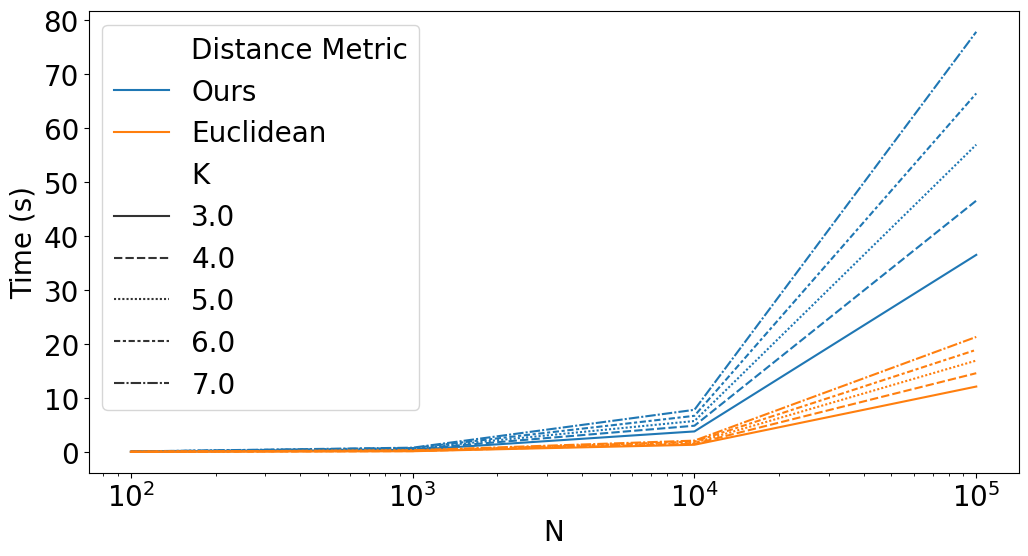

24/05/31 13:50:18 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 924787 ms exceeds timeout 120000 ms
24/05/31 13:50:18 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/31 13:50:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [42]:
import seaborn as sns

fontsize = 20
# Plot the results
plt.figure(figsize = (12, 6))
sns.lineplot(data = melted_times, x = "N", y = "Time (s)", hue = "Distance Metric", style = "K")
plt.xlabel("N", fontsize = fontsize)
plt.ylabel("Time (s)", fontsize = fontsize)
# Log scale x-xis
plt.xscale("log")
#plt.title("K-means Runtime vs. N", fontsize = fontsize)
plt.legend(fontsize = fontsize, title_fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.show()